In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

from sklearn import preprocessing
from sklearn.preprocessing import scale
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.neighbors import  KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier


from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split, StratifiedKFold

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


#### Загрузка данных

In [2]:
train_data = pd.read_csv('train_data.csv')
train_target = pd.read_csv('train_target.csv', names=['Prediction'])

for col in train_data.columns:
    print("{0}, num. NA's: {1}".format(col, pd.isnull(train_data[col]).sum()))

age, num. NA's: 0
job, num. NA's: 0
marital, num. NA's: 0
education, num. NA's: 0
default, num. NA's: 0
housing, num. NA's: 0
loan, num. NA's: 0
contact, num. NA's: 0
month, num. NA's: 0
day_of_week, num. NA's: 0
duration, num. NA's: 0
campaign, num. NA's: 0
pdays, num. NA's: 0
previous, num. NA's: 0
poutcome, num. NA's: 0
emp.var.rate, num. NA's: 0
cons.price.idx, num. NA's: 0
cons.conf.idx, num. NA's: 0
euribor3m, num. NA's: 0
nr.employed, num. NA's: 0


#### One-hot кодирование номинальных признаков

In [5]:
train_data.info(memory_usage='deep')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27595 entries, 0 to 27594
Data columns (total 20 columns):
age               27595 non-null int64
job               27595 non-null object
marital           27595 non-null object
education         27595 non-null object
default           27595 non-null object
housing           27595 non-null object
loan              27595 non-null object
contact           27595 non-null object
month             27595 non-null object
day_of_week       27595 non-null object
duration          27595 non-null int64
campaign          27595 non-null int64
pdays             27595 non-null int64
previous          27595 non-null int64
poutcome          27595 non-null object
emp.var.rate      27595 non-null float64
cons.price.idx    27595 non-null float64
cons.conf.idx     27595 non-null float64
euribor3m         27595 non-null float64
nr.employed       27595 non-null float64
dtypes: float64(5), int64(5), object(10)
memory usage: 18.7 MB


In [7]:
for dtype in list(set(train_data.dtypes)):
    selected_dtype = train_data.select_dtypes(include=[dtype])
    mean_usage_b = selected_dtype.memory_usage(deep=True).mean()
    mean_usage_mb = mean_usage_b / 1024 ** 2
    print("Average memory usage for {} columns: {:03.2f} MB".format(dtype,mean_usage_mb))

Average memory usage for object columns: 1.51 MB
Average memory usage for int64 columns: 0.18 MB
Average memory usage for float64 columns: 0.18 MB


In [8]:
# We're going to be calculating memory usage a lot,
# so we'll create a function to save us some time!

def mem_usage(pandas_obj):
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: # we assume if not a df it's a series
        usage_b  = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 # convert bytes to megabytes
    return "{:03.2f} MB".format(usage_mb)


In [9]:
gl_int = train_data.select_dtypes(include=['int'])
converted_int = gl_int.apply(pd.to_numeric,downcast='unsigned')

print(mem_usage(gl_int))
print(mem_usage(converted_int))

compare_ints = pd.concat([gl_int.dtypes,converted_int.dtypes],axis=1)
compare_ints.columns = ['before','after']
compare_ints.apply(pd.Series.value_counts)

1.05 MB
0.18 MB


,before,after
uint8,NaN,3.0
uint16,NaN,2.0
int64,5.0,NaN


In [10]:
gl_float = train_data.select_dtypes(include=['float'])
converted_float = gl_float.apply(pd.to_numeric,downcast='float')

print(mem_usage(gl_float))
print(mem_usage(converted_float))

compare_floats = pd.concat([gl_float.dtypes,converted_float.dtypes],axis=1)
compare_floats.columns = ['before','after']
compare_floats.apply(pd.Series.value_counts)

1.05 MB
0.53 MB


,before,after
float32,NaN,5.0
float64,5.0,NaN


In [11]:
print(mem_usage(train_data))

train_data[converted_int.columns] = converted_int
train_data[converted_float.columns] = converted_float

print(mem_usage(train_data))


18.72 MB
17.32 MB


In [12]:
mem_usage(train_data.select_dtypes(['object']))


'16.61 MB'

In [13]:
gl_obj = train_data.select_dtypes(include=['object'])

converted_obj = pd.DataFrame()

for col in gl_obj.columns:
    num_unique_values = len(gl_obj[col].unique())
    num_total_values = len(gl_obj[col])
    if num_unique_values / num_total_values < 0.5:
        converted_obj.loc[:,col] = gl_obj[col].astype('category')
    else:
        converted_obj.loc[:,col] = gl_obj[col]
        

In [15]:
print(mem_usage(gl_obj))
print(mem_usage(converted_obj))

compare_obj = pd.concat([gl_obj.dtypes,converted_obj.dtypes],axis=1)
compare_obj.columns = ['before','after']
compare_obj.apply(pd.Series.value_counts)

16.61 MB
0.27 MB


TypeError: data type not understood

Exception ignored in: 'pandas._libs.lib.array_equivalent_object'
TypeError: data type not understood


,before,after
object,10.0,NaN
category,NaN,10.0


In [16]:
train_data[converted_obj.columns] = converted_obj


In [17]:
mem_usage(train_data)


'0.98 MB'

In [18]:
train_data.dtypes


age                  uint8
job               category
marital           category
education         category
default           category
housing           category
loan              category
contact           category
month             category
day_of_week       category
duration            uint16
campaign             uint8
pdays               uint16
previous             uint8
poutcome          category
emp.var.rate       float32
cons.price.idx     float32
cons.conf.idx      float32
euribor3m          float32
nr.employed        float32
dtype: object

In [21]:
dtypes = train_data.dtypes

dtypes_col = dtypes.index
dtypes_type = [i.name for i in dtypes.values]

column_types = dict(zip(dtypes_col, dtypes_type))

# rather than print all 161 items, we'll
# sample 10 key/value pairs from the dict
# and print it nicely using prettyprint

preview = first2pairs = {key:value for key,value in list(column_types.items())[:10]}
import pprint
pp = pp = pprint.PrettyPrinter(indent=4)
pp.pprint(preview)

{   'age': 'uint8',
    'contact': 'category',
    'day_of_week': 'category',
    'default': 'category',
    'education': 'category',
    'housing': 'category',
    'job': 'category',
    'loan': 'category',
    'marital': 'category',
    'month': 'category'}


In [22]:
read_and_optimized = pd.read_csv('train_data.csv',dtype=column_types)

print(mem_usage(read_and_optimized))
read_and_optimized.head()

0.98 MB


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,26,student,single,high.school,no,no,no,telephone,jun,mon,901,1,999,0,nonexistent,1.4,94.464996,-41.799999,4.961,5228.100098
1,46,admin.,married,university.degree,no,yes,no,cellular,aug,tue,208,2,999,0,nonexistent,1.4,93.444000,-36.099998,4.963,5228.100098
2,49,blue-collar,married,basic.4y,unknown,yes,yes,telephone,jun,tue,131,5,999,0,nonexistent,1.4,94.464996,-41.799999,4.864,5228.100098
3,31,technician,married,university.degree,no,no,no,cellular,jul,tue,404,1,999,0,nonexistent,-2.9,92.469002,-33.599998,1.044,5076.200195
4,42,housemaid,married,university.degree,no,yes,no,telephone,nov,mon,85,1,999,0,nonexistent,-0.1,93.199997,-42.000000,4.191,5195.799805


In [26]:
sample = pd.read_csv('train_data.csv', nrows=100)

In [3]:
def encode_nominals(columns, data):
    print('Feature encoding started...\n')
    encoder = LabelEncoder()
    for name in columns:
        print('Current name: ', name)
        encoder.fit(data[name].drop_duplicates())
        labels = list(set(encoder.transform(data[name])))
        # work with binary features
        dummy_features = pd.get_dummies(data[name])
        headers = dummy_features.columns.tolist()
        for header in range(len(headers)):
            if (name=='default'):
                headers[header] = 'default_' + headers[header]
            elif (name=='marital'):
                headers[header] = 'marital' + headers[header]
            elif (name=='education'):
                headers[header] = 'education' + headers[header]
            elif (name=='housing'):
                headers[header] = 'housing_' + headers[header]
            elif (name=='loan'):
                headers[header] = 'loan_' + headers[header]
            elif name=='job':
                headers[header] = headers[header] + '_job'
            elif name=='contact':
                headers[header] = headers[header] + '_contact'
            elif name=='month':
                headers[header] = headers[header]
            elif name=='day_of_week':
                headers[header] = headers[header]
            elif name=='poutcome':
                headers[header] = 'poutcome_' + headers[header]
        dummy_features.columns = headers
            # append new features to dataset
        data = data.join(dummy_features)
            # delete encoded feature
        data = data.drop(name, axis=1)
        print("\t Feature '%s' - encoded correctly" % name)
            
    print('\nFeature encoding finished!')
    return data

Проведем one hot кодирование категориальных признаков в нашем датасете. Также удалим признак default_yes, потому что для признака default значение yes в тестовых данных не встречается вообще.

In [4]:
columns = ['job', 'marital', 'education', 'housing', 'loan', 'contact',
               'month', 'day_of_week','poutcome', 'default']

# encode nominal features
train_data = encode_nominals(columns, train_data)
# make final dataset
data = train_data.join(train_target)

data.drop('default_yes', 1, inplace=True)

Feature encoding started...

Current name:  job
	 Feature 'job' - encoded correctly
Current name:  marital
	 Feature 'marital' - encoded correctly
Current name:  education
	 Feature 'education' - encoded correctly
Current name:  housing
	 Feature 'housing' - encoded correctly
Current name:  loan
	 Feature 'loan' - encoded correctly
Current name:  contact
	 Feature 'contact' - encoded correctly
Current name:  month
	 Feature 'month' - encoded correctly
Current name:  day_of_week
	 Feature 'day_of_week' - encoded correctly
Current name:  poutcome
	 Feature 'poutcome' - encoded correctly
Current name:  default
	 Feature 'default' - encoded correctly

Feature encoding finished!


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001700943F940>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000001700D0A8C18>]], dtype=object)

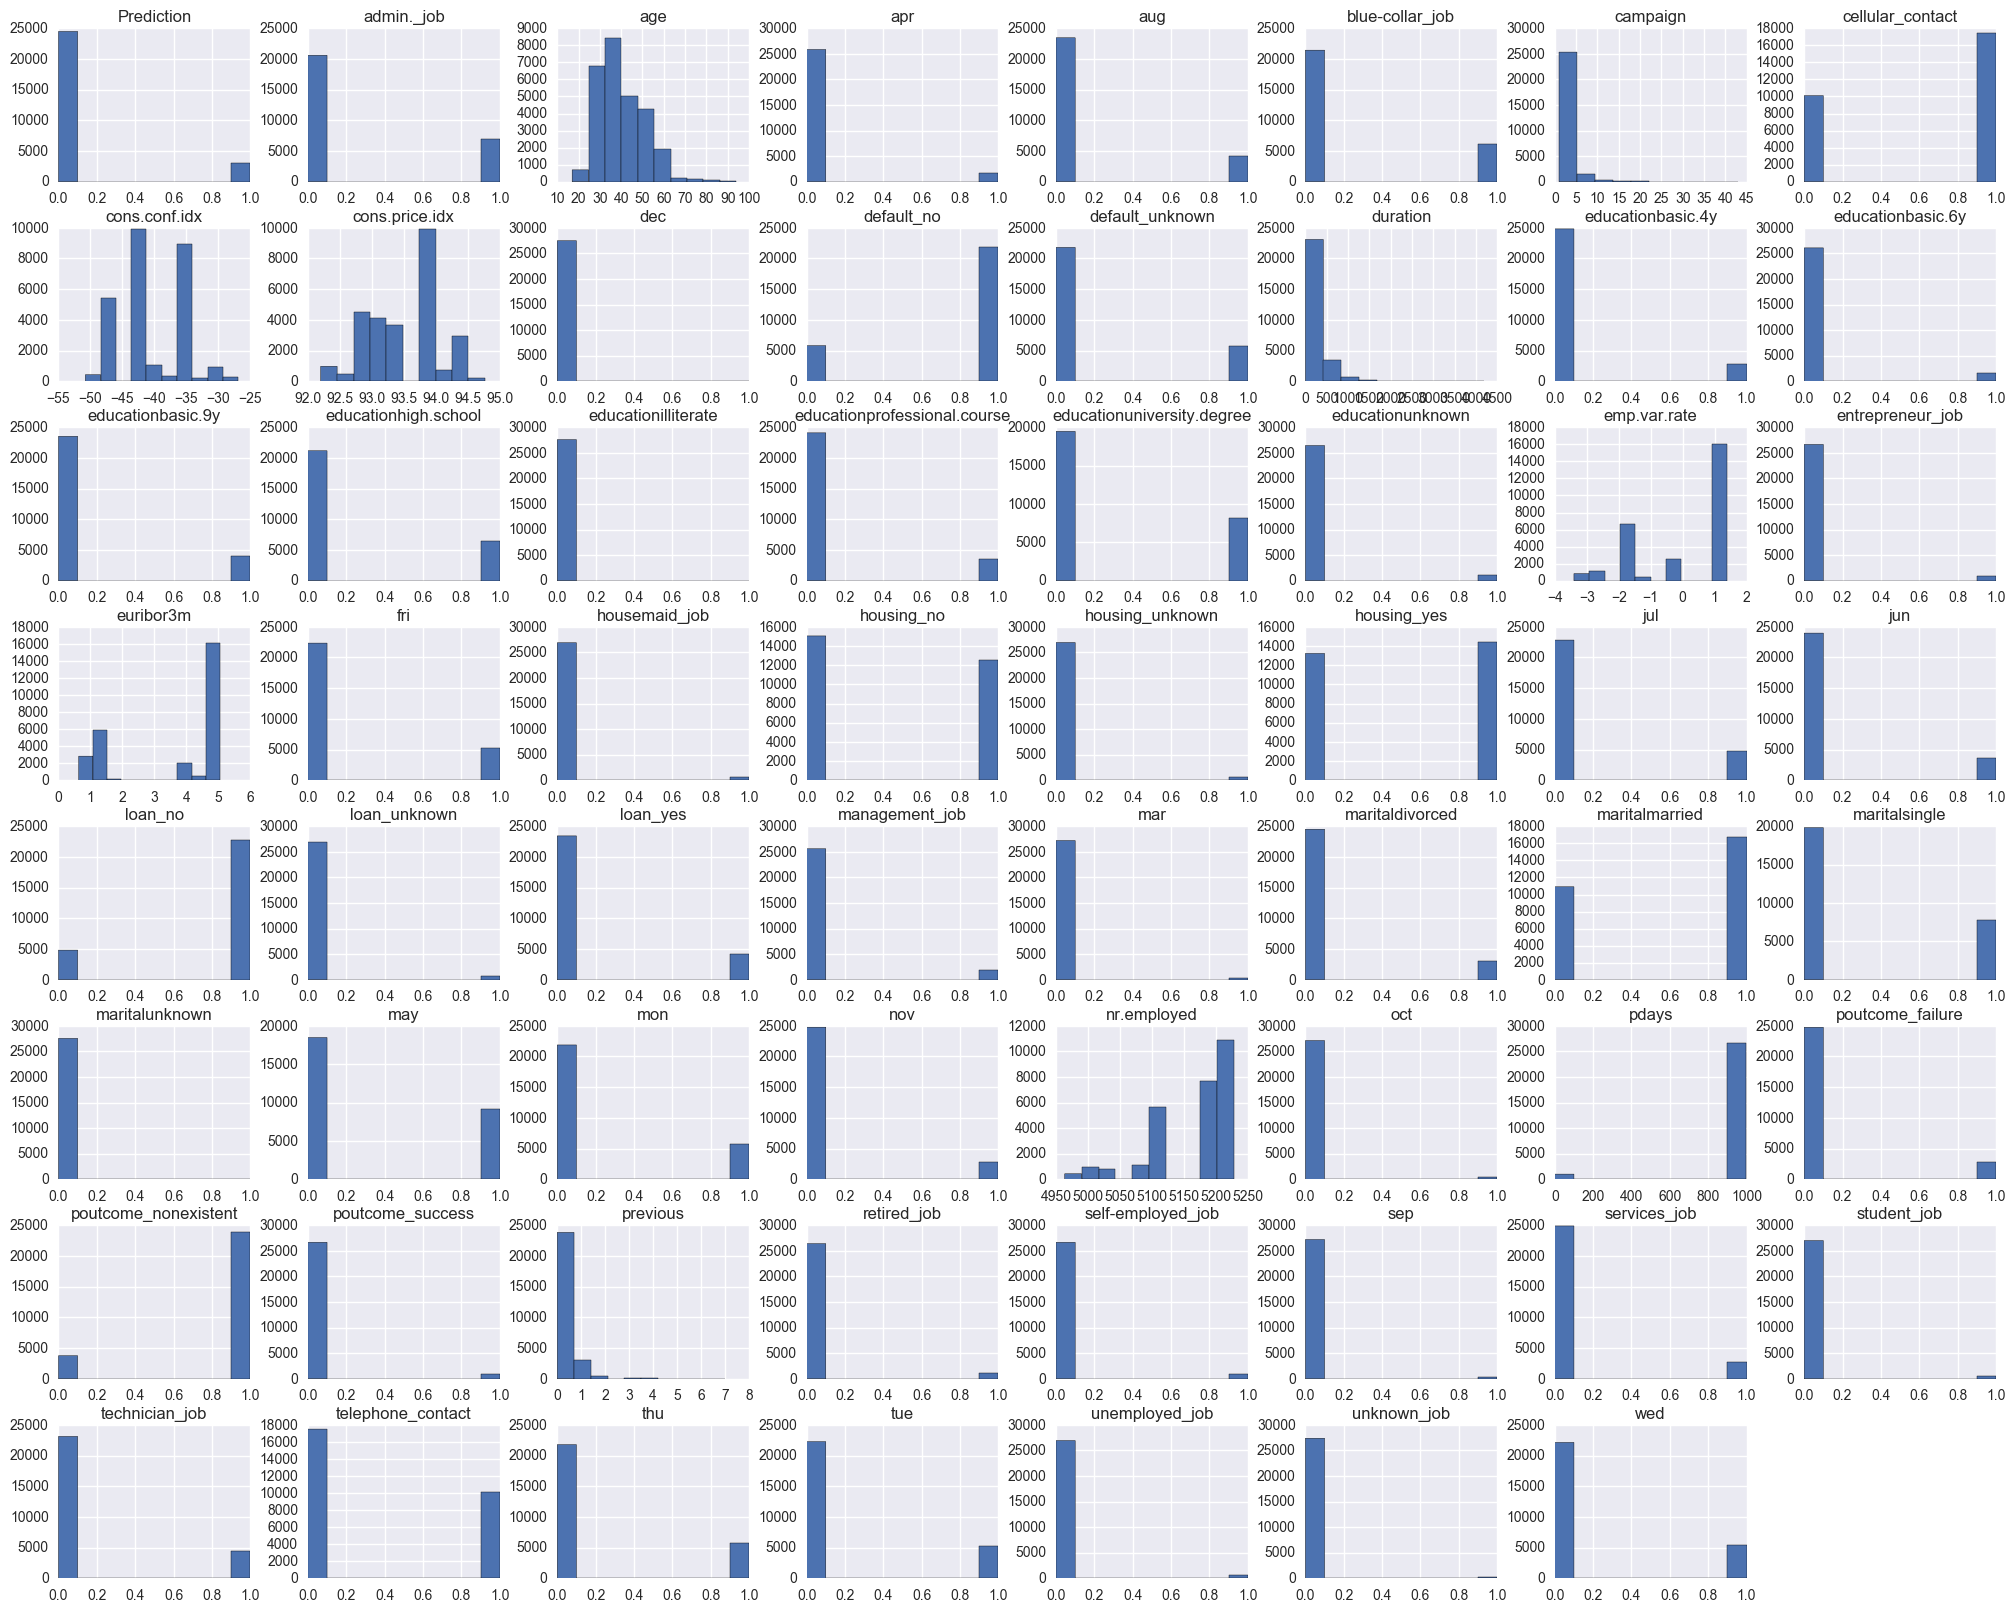

In [5]:
data.hist(figsize=(25,20))

Посмотрим на корреляции признаков с нашей целевой переменной.

In [7]:
data[data.columns[:-1]].corrwith(data.Prediction)

age                           0.032164
duration                      0.408124
campaign                     -0.071472
pdays                        -0.326604
previous                      0.233072
emp.var.rate                 -0.299526
cons.price.idx               -0.136918
cons.conf.idx                 0.051229
euribor3m                    -0.308978
nr.employed                  -0.353859
admin._job                    0.030678
blue-collar_job              -0.075399
entrepreneur_job             -0.019845
housemaid_job                -0.000737
management_job               -0.000007
retired_job                   0.087357
self-employed_job            -0.007039
services_job                 -0.030989
student_job                   0.098924
technician_job               -0.005728
unemployed_job                0.014419
unknown_job                   0.002498
maritaldivorced              -0.009789
maritalmarried               -0.043256
maritalsingle                 0.053461
maritalunknown           

In [8]:
X = data[data.columns[:-1]].values

# Определяем целевую переменную
y = data.Prediction.values

In [9]:
# Разбиваем выборку train & test
skf = StratifiedKFold(y, n_folds=10, shuffle=True, random_state=2016)
for train_ind, valid_ind in skf:
    X_train, X_test = X[train_ind], X[valid_ind]
    y_train, y_test = y[train_ind], y[valid_ind]

Посмотрим, какое качество показывают различные алгоритмы и начнем их настройку.

## Non-configured KNN

In [10]:
roc_auc_score(y_test, KNeighborsClassifier().fit(X_train, y_train).
             predict_proba(X_test)[:,1])

0.89306842779984452

## Non-configured RF

In [11]:
rf = RandomForestClassifier(n_jobs=-1, random_state=2042)
rf.fit(X_train, y_train)
roc_auc_score(y_test, rf.predict_proba(X_test)[:,1])

0.91188883109513896

## Non-configured GB

In [12]:
gb = GradientBoostingClassifier(random_state=2042).fit(X_train, y_train)
roc_auc_score(y_test, gb.predict_proba(X_test)[:,1])

0.95122141836370133

## AdaBoost

In [13]:
ada = AdaBoostClassifier(random_state=2042, n_estimators=100, learning_rate=1.0).fit(X_train, y_train)
roc_auc_score(y_test, ada.predict_proba(X_test)[:,1])

0.94505587604816843

## Non-configured MLP

In [14]:
mlp = MLPClassifier().fit(X_train, y_train)
roc_auc_score(y_test, mlp.predict_proba(X_test)[:,1])

0.93083007586743161

# Selecting Best Features

In [15]:
importance = rf.feature_importances_
importances_table = pd.DataFrame(columns=['feature','importance'])
importances_table.feature = data.columns[:-1]

for i in range(len(importances_table.feature)):
    importances_table.importance[i] = round(importance[i]*100, 2)

importances_table = importances_table.sort('importance', ascending=False)

for i in range(len(importances_table.feature)):
    importances_table.importance[i] = str(round(importance[i]*100, 2))+'%'

best_features = list(importances_table.feature.values[:6])

importances_table[:6]

,feature,importance
1,duration,27.46%
0,age,7.77%
9,nr.employed,7.31%
8,euribor3m,6.87%
2,campaign,3.85%
7,cons.conf.idx,3.01%


In [326]:
#best_features

['duration', 'euribor3m', 'age', 'campaign', 'nr.employed', 'cons.conf.idx']

In [320]:
# Making dataset with only important features
#new_data = data[best_features].join(train_target)

#X = new_data[new_data.columns[:-1]]

#X_train, X_test, y_train, y_test = train_test_split(new_X, y, test_size=0.4,
#                                                    random_state=2042, stratify=y)

Проведем настройку градиентного бустинга на тренировочных данных.

# Configuring GB

In [23]:
gb1 = GradientBoostingClassifier(random_state=20).fit(X_train, y_train)
roc_auc_score(y_test, gb1.predict_proba(X_test)[:,1])

0.94497429386478293

In [24]:
%%time
gb_param_test1 = {'n_estimators' : np.arange(20, 101, 10) }
gsearch_gb1 = GridSearchCV(GradientBoostingClassifier(max_depth=8, min_samples_leaf=40, min_samples_split=400,
                                                      max_features='sqrt', subsample=0.8,random_state=20),
                                                      gb_param_test1, scoring='roc_auc', cv=5).fit(X_train, y_train)

Wall time: 1min 6s


In [25]:
gsearch_gb1.grid_scores_, gsearch_gb1.best_params_, gsearch_gb1.best_score_

([mean: 0.93566, std: 0.00441, params: {'n_estimators': 20},
  mean: 0.93921, std: 0.00419, params: {'n_estimators': 30},
  mean: 0.94173, std: 0.00315, params: {'n_estimators': 40},
  mean: 0.94301, std: 0.00288, params: {'n_estimators': 50},
  mean: 0.94381, std: 0.00292, params: {'n_estimators': 60},
  mean: 0.94453, std: 0.00265, params: {'n_estimators': 70},
  mean: 0.94462, std: 0.00258, params: {'n_estimators': 80},
  mean: 0.94495, std: 0.00245, params: {'n_estimators': 90},
  mean: 0.94517, std: 0.00217, params: {'n_estimators': 100}],
 {'n_estimators': 100},
 0.9451651893955815)

In [26]:
%%time
gb_param_test2 = {'n_estimators' : np.arange(100, 1001, 200) }
gsearch_gb2 = GridSearchCV(GradientBoostingClassifier(max_depth=8, min_samples_leaf=40, min_samples_split=400,
                                                      max_features='sqrt', subsample=0.8,random_state=20),
                                                      gb_param_test2, scoring='roc_auc', cv=5).fit(X_train, y_train)

Wall time: 5min 8s


In [27]:
gsearch_gb2.grid_scores_, gsearch_gb2.best_params_, gsearch_gb2.best_score_

([mean: 0.94517, std: 0.00217, params: {'n_estimators': 100},
  mean: 0.94431, std: 0.00242, params: {'n_estimators': 300},
  mean: 0.94261, std: 0.00237, params: {'n_estimators': 500},
  mean: 0.94126, std: 0.00218, params: {'n_estimators': 700},
  mean: 0.94011, std: 0.00252, params: {'n_estimators': 900}],
 {'n_estimators': 100},
 0.9451651893955815)

In [28]:
%%time
gb_param_test3 = {'min_samples_split' : np.arange(200, 1201, 200),
               'max_depth' : [4, 6, 7, 8]}

gsearch_gb3 = GridSearchCV(GradientBoostingClassifier(n_estimators=100, max_features='sqrt',
                                                      subsample=0.8, random_state=2042),
                                                      gb_param_test3, scoring='roc_auc',
                                                      cv=5, n_jobs=-1).fit(X_train, y_train)

Wall time: 2min 18s


In [29]:
gsearch_gb3.grid_scores_, gsearch_gb3.best_params_, gsearch_gb3.best_score_

([mean: 0.94258, std: 0.00265, params: {'min_samples_split': 200, 'max_depth': 4},
  mean: 0.94273, std: 0.00224, params: {'min_samples_split': 400, 'max_depth': 4},
  mean: 0.94206, std: 0.00255, params: {'min_samples_split': 600, 'max_depth': 4},
  mean: 0.94132, std: 0.00255, params: {'min_samples_split': 800, 'max_depth': 4},
  mean: 0.94104, std: 0.00237, params: {'min_samples_split': 1000, 'max_depth': 4},
  mean: 0.94086, std: 0.00281, params: {'min_samples_split': 1200, 'max_depth': 4},
  mean: 0.94455, std: 0.00234, params: {'min_samples_split': 200, 'max_depth': 6},
  mean: 0.94503, std: 0.00221, params: {'min_samples_split': 400, 'max_depth': 6},
  mean: 0.94424, std: 0.00214, params: {'min_samples_split': 600, 'max_depth': 6},
  mean: 0.94393, std: 0.00305, params: {'min_samples_split': 800, 'max_depth': 6},
  mean: 0.94381, std: 0.00233, params: {'min_samples_split': 1000, 'max_depth': 6},
  mean: 0.94330, std: 0.00285, params: {'min_samples_split': 1200, 'max_depth': 6},


In [30]:
%%time
gb_param_test4 = {'min_samples_leaf' : np.arange(30, 151, 20)}

gsearch_gb4 = GridSearchCV(GradientBoostingClassifier(n_estimators=100, max_features='sqrt', max_depth=8,
                                                      min_samples_split=400, subsample=0.8,
                                                      random_state=2042),gb_param_test4,
                           scoring='roc_auc', cv=5, n_jobs=-1, verbose=True).fit(X_train, y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   52.8s finished


Wall time: 56.8 s


In [31]:
gsearch_gb4.grid_scores_, gsearch_gb4.best_params_, gsearch_gb4.best_score_

([mean: 0.94524, std: 0.00266, params: {'min_samples_leaf': 30},
  mean: 0.94458, std: 0.00235, params: {'min_samples_leaf': 50},
  mean: 0.94477, std: 0.00280, params: {'min_samples_leaf': 70},
  mean: 0.94438, std: 0.00282, params: {'min_samples_leaf': 90},
  mean: 0.94394, std: 0.00235, params: {'min_samples_leaf': 110},
  mean: 0.94367, std: 0.00302, params: {'min_samples_leaf': 130},
  mean: 0.94401, std: 0.00296, params: {'min_samples_leaf': 150}],
 {'min_samples_leaf': 30},
 0.9452387985326133)

In [34]:
%%time
gb_param_test5 = {'subsample' : [0.6, 0.7, 0.75, 0.8, 0.85]}

gsearch_gb5 = GridSearchCV(GradientBoostingClassifier(n_estimators=100, max_depth=8, min_samples_leaf=30,
                                                    min_samples_split=400, max_features='sqrt', random_state=2042),
                                                      gb_param_test5, scoring='roc_auc',
                           cv=5, n_jobs=-1).fit(X_train, y_train)

Wall time: 41.4 s


In [35]:
gsearch_gb5.grid_scores_, gsearch_gb5.best_params_, gsearch_gb5.best_score_

([mean: 0.94336, std: 0.00292, params: {'subsample': 0.6},
  mean: 0.94435, std: 0.00251, params: {'subsample': 0.7},
  mean: 0.94505, std: 0.00289, params: {'subsample': 0.75},
  mean: 0.94524, std: 0.00266, params: {'subsample': 0.8},
  mean: 0.94550, std: 0.00213, params: {'subsample': 0.85}],
 {'subsample': 0.85},
 0.9454995333001862)

In [19]:
%%time
tuned_gb1 = GradientBoostingClassifier(n_estimators=100, max_depth=8, min_samples_leaf=30, learning_rate=0.1,
                                                    min_samples_split=400, max_features='sqrt',
                                       random_state=2042, subsample=0.85).fit(X_train, y_train)

Wall time: 3.68 s


In [20]:
roc_auc_score(y_test, tuned_gb1.predict_proba(X_test)[:,1])

0.95006488661917077

In [25]:
comp1 = VotingClassifier(estimators=(('gb', tuned_gb1), ('ada', ada)), voting='soft').fit(X_train, y_train)

In [26]:
roc_auc_score(y_test, comp1.predict_proba(X_test)[:,1])

0.95063231616333566

Попытаемся добиться лучшего качества, попробовав добавить исскуственных объектов с целью сделать выборку сбалансированнее. Для этого воспользуемся RandomOverSampler.

# Over Sampling Train Data

In [27]:
from imblearn.over_sampling import RandomOverSampler
verbose = False
ratio = 'auto'
# 'Random over-sampling'
OS = RandomOverSampler(ratio=ratio)

osX_train1, osy_train1 = OS.fit_sample(X_train, y_train.reshape(-1, 1))

## Random Forest on OS Train

In [65]:
os_Xtrain_rf = RandomForestClassifier(n_estimators=500, min_samples_split=400, min_samples_leaf=50,
                                   max_depth=8, max_features='sqrt', n_jobs=-1, random_state=2042)
os_rf.fit(osX_train1, osy_train1)
roc_auc_score(y_test, os_rf.predict_proba(X_test)[:,1])

0.87504132192375983

## Grad Boost on OS Train

In [40]:
os_Xtrain_gb = GradientBoostingClassifier(n_estimators=400, min_samples_split=400, min_samples_leaf=50,
                                   max_depth=8, max_features='sqrt', subsample=0.8,
                                   learning_rate=0.01, random_state=2042).fit(osX_train1, osy_train1)
roc_auc_score(y_test, os_Xtrain_gb.predict_proba(X_test)[:,1])

0.94530518656080031

## MLP on OS Train

In [123]:
os_Xtrain_mlp = MLPClassifier(hidden_layer_sizes=(175, 150)).fit(osX_train1, osy_train1)
roc_auc_score(y_test, os_Xtrain_mlp.predict_proba(X_test)[:,1])

0.93449997898409087

Проведем настройку случайного леса и градиентного бустинга на сбалансированных данных.

# Trying to configure RF on os train

In [159]:
rf_OSX_train = RandomForestClassifier(n_jobs=-1).fit(osX_train1, osy_train1)
roc_auc_score(y_test, rf_OSX_train.predict_proba(X_test)[:,1])

0.92050827741927033

In [104]:
%%time
rf_param_test1 = {'n_estimators' : np.arange(20, 128, 20) }

gsearch_rf1 = GridSearchCV(RandomForestClassifier(n_jobs=-1, random_state=2042, min_samples_split=400,
                                                  min_samples_leaf=50, max_depth=8, max_features='sqrt'),
                           rf_param_test1, scoring='roc_auc', cv=5).fit(osX_train1, osy_train1)

Wall time: 43.4 s


In [105]:
gsearch_rf1.grid_scores_, gsearch_rf1.best_params_, gsearch_rf1.best_score_

([mean: 0.93309, std: 0.00403, params: {'n_estimators': 20},
  mean: 0.93482, std: 0.00345, params: {'n_estimators': 40},
  mean: 0.93464, std: 0.00284, params: {'n_estimators': 60},
  mean: 0.93405, std: 0.00320, params: {'n_estimators': 80},
  mean: 0.93353, std: 0.00324, params: {'n_estimators': 100},
  mean: 0.93364, std: 0.00337, params: {'n_estimators': 120}],
 {'n_estimators': 40},
 0.9348245170606972)

In [106]:
%%time
rf_param_test3 = {'min_samples_split' : np.arange(200, 601, 100),
               'max_depth' : [6, 7, 8, 10]}

gsearch_rf3 = GridSearchCV(RandomForestClassifier(n_jobs=-1, n_estimators=40, random_state=2042, max_features='sqrt'),
                           rf_param_test3, scoring='roc_auc', cv=5).fit(osX_train1, osy_train1)

Wall time: 1min 28s


In [107]:
gsearch_rf3.grid_scores_, gsearch_rf3.best_params_, gsearch_rf3.best_score_

([mean: 0.92738, std: 0.00453, params: {'min_samples_split': 200, 'max_depth': 6},
  mean: 0.92683, std: 0.00471, params: {'min_samples_split': 300, 'max_depth': 6},
  mean: 0.92450, std: 0.00480, params: {'min_samples_split': 400, 'max_depth': 6},
  mean: 0.92456, std: 0.00495, params: {'min_samples_split': 500, 'max_depth': 6},
  mean: 0.92381, std: 0.00428, params: {'min_samples_split': 600, 'max_depth': 6},
  mean: 0.93335, std: 0.00386, params: {'min_samples_split': 200, 'max_depth': 7},
  mean: 0.93039, std: 0.00249, params: {'min_samples_split': 300, 'max_depth': 7},
  mean: 0.92932, std: 0.00480, params: {'min_samples_split': 400, 'max_depth': 7},
  mean: 0.92976, std: 0.00477, params: {'min_samples_split': 500, 'max_depth': 7},
  mean: 0.92979, std: 0.00626, params: {'min_samples_split': 600, 'max_depth': 7},
  mean: 0.93910, std: 0.00357, params: {'min_samples_split': 200, 'max_depth': 8},
  mean: 0.93582, std: 0.00322, params: {'min_samples_split': 300, 'max_depth': 8},
  me

In [108]:
%%time
rf_param_test4 = {'min_samples_leaf' : np.arange(30, 80, 10)}

gsearch_rf4 = GridSearchCV(RandomForestClassifier(n_jobs=-1, min_samples_split=200, max_depth=10,
                                                  n_estimators=40, random_state=2042, max_features='sqrt'),
                           rf_param_test4, scoring='roc_auc', cv=5).fit(osX_train1, osy_train1)

Wall time: 24.8 s


In [109]:
gsearch_rf4.grid_scores_, gsearch_rf4.best_params_, gsearch_rf4.best_score_

([mean: 0.94227, std: 0.00447, params: {'min_samples_leaf': 30},
  mean: 0.94239, std: 0.00406, params: {'min_samples_leaf': 40},
  mean: 0.94183, std: 0.00475, params: {'min_samples_leaf': 50},
  mean: 0.93991, std: 0.00525, params: {'min_samples_leaf': 60},
  mean: 0.93983, std: 0.00493, params: {'min_samples_leaf': 70}],
 {'min_samples_leaf': 40},
 0.9423894752664023)

In [110]:
%%time
rf_param_test5 = {'max_features' : ['log2', 'sqrt']}

gsearch_rf5 = GridSearchCV(RandomForestClassifier(n_jobs=-1, n_estimators=40, max_depth=12, min_samples_leaf=30,
                                                  min_samples_split=200, random_state=2042)
                                                 ,rf_param_test5, scoring='roc_auc', cv=5).fit(osX_train1, osy_train1)

Wall time: 10.7 s


In [111]:
gsearch_rf5.grid_scores_, gsearch_rf5.best_params_, gsearch_rf5.best_score_

([mean: 0.93648, std: 0.00444, params: {'max_features': 'log2'},
  mean: 0.94633, std: 0.00337, params: {'max_features': 'sqrt'}],
 {'max_features': 'sqrt'},
 0.9463347420775504)

In [17]:
tuned_rf_withOS_Xtrain = RandomForestClassifier(n_jobs=-1, n_estimators=1000, max_depth=10,
                                                min_samples_leaf=30, min_samples_split=200, random_state=2042,
                                                max_features='sqrt').fit(osX_train1, osy_train1)

roc_auc_score(y_test, tuned_rf_withOS_Xtrain.predict_proba(X_test)[:,1])

0.93885946661622843

In [361]:
# without OS
tuned_rf = RandomForestClassifier(n_jobs=-1, n_estimators=100, max_depth=12,
                                                min_samples_leaf=30, min_samples_split=200, random_state=2042,
                                                max_features='sqrt').fit(X_train, y_train)

In [362]:
roc_auc_score(y_test, tuned_rf.predict_proba(X_test)[:,1])

0.93360310077067388

# Trying to configure GB on os train

In [189]:
gb_OSX_train = GradientBoostingClassifier(random_state=2042).fit(osX_train1, osy_train1)
roc_auc_score(y_test, gb_OSX_train.predict_proba(X_test)[:,1])

0.94606572957466428

In [41]:
%%time
gb_param_test1 = {'n_estimators' : np.arange(20, 81, 10) }
gsearch_gb1 = GridSearchCV(GradientBoostingClassifier(max_depth=8, min_samples_leaf=40, min_samples_split=400,
                                                      max_features='sqrt', subsample=0.8,random_state=2042),
                                                      gb_param_test1, scoring='roc_auc', cv=5).fit(osX_train1, osy_train1)

Wall time: 1min 36s


In [42]:
gsearch_gb1.grid_scores_, gsearch_gb1.best_params_, gsearch_gb1.best_score_

([mean: 0.94863, std: 0.00379, params: {'n_estimators': 20},
  mean: 0.95195, std: 0.00386, params: {'n_estimators': 30},
  mean: 0.95500, std: 0.00372, params: {'n_estimators': 40},
  mean: 0.95705, std: 0.00309, params: {'n_estimators': 50},
  mean: 0.95912, std: 0.00280, params: {'n_estimators': 60},
  mean: 0.96062, std: 0.00289, params: {'n_estimators': 70},
  mean: 0.96171, std: 0.00271, params: {'n_estimators': 80}],
 {'n_estimators': 80},
 0.9617114144042802)

In [43]:
%%time
gb_param_test3 = {'min_samples_split' : np.arange(200, 1001, 200),
               'max_depth' : [5, 6, 7, 8, 10]}

gsearch_gb3 = GridSearchCV(GradientBoostingClassifier(n_estimators=80, max_features='sqrt',
                                                      subsample=0.8, random_state=2042,
                                                     min_samples_leaf=50),
                                                      gb_param_test3, scoring='roc_auc',
                                                      cv=5, n_jobs=-1).fit(osX_train1, osy_train1)

Wall time: 4min 34s


In [44]:
gsearch_gb3.grid_scores_, gsearch_gb3.best_params_, gsearch_gb3.best_score_

([mean: 0.95422, std: 0.00292, params: {'min_samples_split': 200, 'max_depth': 5},
  mean: 0.95353, std: 0.00264, params: {'min_samples_split': 400, 'max_depth': 5},
  mean: 0.95253, std: 0.00304, params: {'min_samples_split': 600, 'max_depth': 5},
  mean: 0.95248, std: 0.00300, params: {'min_samples_split': 800, 'max_depth': 5},
  mean: 0.95157, std: 0.00337, params: {'min_samples_split': 1000, 'max_depth': 5},
  mean: 0.95735, std: 0.00305, params: {'min_samples_split': 200, 'max_depth': 6},
  mean: 0.95630, std: 0.00280, params: {'min_samples_split': 400, 'max_depth': 6},
  mean: 0.95571, std: 0.00328, params: {'min_samples_split': 600, 'max_depth': 6},
  mean: 0.95491, std: 0.00317, params: {'min_samples_split': 800, 'max_depth': 6},
  mean: 0.95367, std: 0.00351, params: {'min_samples_split': 1000, 'max_depth': 6},
  mean: 0.96078, std: 0.00267, params: {'min_samples_split': 200, 'max_depth': 7},
  mean: 0.95912, std: 0.00314, params: {'min_samples_split': 400, 'max_depth': 7},
  

In [45]:
%%time
gb_param_test4 = {'min_samples_leaf' : [20, 40, 70, 100, 500, 1000]}

gsearch_gb4 = GridSearchCV(GradientBoostingClassifier(n_estimators=100, max_features='sqrt', max_depth=10,
                                                      min_samples_split=200, subsample=0.8,
                                                      random_state=2042),gb_param_test4,
                           scoring='roc_auc', cv=5, n_jobs=-1).fit(osX_train1, osy_train1)

Wall time: 1min 52s


In [46]:
gsearch_gb4.grid_scores_, gsearch_gb4.best_params_, gsearch_gb4.best_score_

([mean: 0.97339, std: 0.00178, params: {'min_samples_leaf': 20},
  mean: 0.97165, std: 0.00195, params: {'min_samples_leaf': 40},
  mean: 0.96958, std: 0.00212, params: {'min_samples_leaf': 70},
  mean: 0.96731, std: 0.00211, params: {'min_samples_leaf': 100},
  mean: 0.95424, std: 0.00254, params: {'min_samples_leaf': 500},
  mean: 0.94820, std: 0.00282, params: {'min_samples_leaf': 1000}],
 {'min_samples_leaf': 20},
 0.9733902910332606)

In [47]:
%%time
gb_param_test5 = {'subsample' : [0.6, 0.7, 0.8, 0.9, 1.0]}

gsearch_gb5 = GridSearchCV(GradientBoostingClassifier(n_estimators=100, max_depth=10, min_samples_leaf=20,
                                                    min_samples_split=200, max_features='sqrt', random_state=2042),
                                                      gb_param_test5, scoring='roc_auc',
                           cv=5, n_jobs=-1).fit(osX_train1, osy_train1)

Wall time: 1min 51s


In [48]:
gsearch_gb5.grid_scores_, gsearch_gb5.best_params_, gsearch_gb5.best_score_

([mean: 0.97126, std: 0.00248, params: {'subsample': 0.6},
  mean: 0.97178, std: 0.00167, params: {'subsample': 0.7},
  mean: 0.97339, std: 0.00178, params: {'subsample': 0.8},
  mean: 0.97428, std: 0.00223, params: {'subsample': 0.9},
  mean: 0.97479, std: 0.00233, params: {'subsample': 1.0}],
 {'subsample': 1.0},
 0.9747870595345428)

In [8]:
%%time
tuned_gb_withOS_Xtrain = GradientBoostingClassifier(n_estimators=1500, max_depth=10, min_samples_leaf=20,
                                                    min_samples_split=200, max_features='sqrt', subsample=0.8,
                                            learning_rate=0.005, random_state=2016, warm_start=True).fit(osX_train1, osy_train1)

Wall time: 3min 2s


In [100]:
roc_auc_score(y_test, tuned_gb_withOS_Xtrain.predict_proba(X_test)[:,1])

0.95137049996847611

In [28]:
%%time

# without OS
tuned_gb = GradientBoostingClassifier(n_estimators=1500, max_depth=10, min_samples_leaf=20,
                                                    min_samples_split=200, max_features='sqrt', subsample=0.8,
                                                    learning_rate=0.005, random_state=2042).fit(X_train, y_train)

Wall time: 1min 12s


In [29]:
roc_auc_score(y_test, tuned_gb.predict_proba(X_test)[:,1])

0.95151892482609346

Попробуем исопльзовать композицию случайного леса и градиентного бустинга. Возможно, это поможет добиться лучших результатов.

# Composition of tuned models on os train

In [115]:
os_Xtrain_eclf_tuned_models = VotingClassifier(estimators=[('gb', tuned_gb_withOS_Xtrain), ('rf', tuned_rf_withOS_Xtrain)],
                                  voting ='soft').fit(osX_train1, osy_train1)

roc_auc_score(y_test, os_Xtrain_eclf_tuned_models.predict_proba(X_test)[:,1])

0.94909290082592523

In [31]:
# without OS
tuned_gb_and_ada = VotingClassifier(estimators=[('gb', tuned_gb), ('ada', ada)],
                                  voting ='soft').fit(X_train, y_train)

roc_auc_score(y_test, tuned_gb_and_ada.predict_proba(X_test)[:,1])

0.9522557951369186

Воспользуемся алгоритмом xgboost как одним из лучших на данных момент с целью получения наилучших результатов.

# XGBoost

In [2]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

OSError: dlopen(/anaconda3/lib/python3.6/site-packages/xgboost/./lib/libxgboost.so, 6): Library not loaded: /usr/local/opt/gcc/lib/gcc/5/libgomp.1.dylib
  Referenced from: /anaconda3/lib/python3.6/site-packages/xgboost/./lib/libxgboost.so
  Reason: image not found

In [51]:
not_tuned_xgb_on_OSXtrain = XGBClassifier().fit(osX_train1, osy_train1)
pred_for_not_tuned_xgb_on_OSXtrain = not_tuned_xgb_on_OSXtrain.predict_proba(X_test)[:,1]
roc_auc_score(y_test, pred_for_not_tuned_xgb_on_OSXtrain)

0.94605377662264967

Проведем настройку параметров xgboost на кросс-валидации.

# Tuning XGBoost

In [205]:
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=100,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27).fit(osX_train1, osy_train1)
roc_auc_score(y_test, xgb1.fit(osX_train1, osy_train1).predict_proba(X_test)[:,1])

0.94867008832065403

In [207]:
%%time
xgb_param_test1 = {'max_depth': np.arange(3,10,2),
                   'min_child_weight': np.arange(1,6,2)}

gsearch_xgb1 = GridSearchCV(XGBClassifier( learning_rate=0.1, n_estimators=100,
 gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 xgb_param_test1, scoring='roc_auc',n_jobs=-1, cv=5).fit(osX_train1, osy_train1)

Wall time: 2min 21s


In [208]:
gsearch_xgb1.grid_scores_, gsearch_xgb1.best_params_, gsearch_xgb1.best_score_

([mean: 0.94951, std: 0.00303, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.94945, std: 0.00297, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.94942, std: 0.00313, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.96107, std: 0.00295, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.95996, std: 0.00288, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.95935, std: 0.00287, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.97310, std: 0.00287, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.97024, std: 0.00305, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.96794, std: 0.00340, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: 0.98306, std: 0.00245, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: 0.97802, std: 0.00266, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: 0.97541, std: 0.00282, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 9, 'min_child_weight': 1

In [209]:
%%time
xgb_param_test2 = {'max_depth': [9, 10, 11, 12]}

gsearch_xgb2 = GridSearchCV(XGBClassifier( learning_rate =0.1, n_estimators=100,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 xgb_param_test2, scoring='roc_auc',n_jobs=-1, cv=5).fit(osX_train1, osy_train1)

Wall time: 1min 26s


In [210]:
gsearch_xgb2.grid_scores_, gsearch_xgb2.best_params_, gsearch_xgb2.best_score_

([mean: 0.98306, std: 0.00245, params: {'max_depth': 9},
  mean: 0.98614, std: 0.00196, params: {'max_depth': 10},
  mean: 0.98864, std: 0.00150, params: {'max_depth': 11},
  mean: 0.99021, std: 0.00151, params: {'max_depth': 12}],
 {'max_depth': 12},
 0.990209565427111)

In [84]:
%%time
xgb_param_test3 = {'gamma' : [0, 0.1, 0.2, 0.3, 0.4]}

gsearch_xgb3 = GridSearchCV(XGBClassifier(max_depth=10, learning_rate =0.1, n_estimators=100,
 min_child_weight=1, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 xgb_param_test3, scoring='roc_auc',n_jobs=-1, cv=5).fit(osX_train1, osy_train1)

Wall time: 2min 11s


In [85]:
gsearch_xgb3.grid_scores_, gsearch_xgb3.best_params_, gsearch_xgb3.best_score_

([mean: 0.98727, std: 0.00151, params: {'gamma': 0},
  mean: 0.98707, std: 0.00149, params: {'gamma': 0.1},
  mean: 0.98726, std: 0.00130, params: {'gamma': 0.2},
  mean: 0.98718, std: 0.00138, params: {'gamma': 0.3},
  mean: 0.98712, std: 0.00144, params: {'gamma': 0.4}],
 {'gamma': 0},
 0.9872714788765482)

In [86]:
%%time
xgb_param_test4 = { 'subsample' : [0.6, 0.7, 0.8, 0.9],
                    'colsample_bytree' : [0.6, 0.7, 0.8, 0.9]}

gsearch_xgb4 = GridSearchCV(XGBClassifier(max_depth=10, learning_rate =0.1, n_estimators=100,
 min_child_weight=1, gamma=0,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 xgb_param_test4, scoring='roc_auc',n_jobs=-1, cv=5).fit(osX_train1, osy_train1)

Wall time: 6min 25s


In [87]:
gsearch_xgb4.grid_scores_, gsearch_xgb4.best_params_, gsearch_xgb4.best_score_

([mean: 0.98745, std: 0.00151, params: {'subsample': 0.6, 'colsample_bytree': 0.6},
  mean: 0.98782, std: 0.00125, params: {'subsample': 0.7, 'colsample_bytree': 0.6},
  mean: 0.98845, std: 0.00143, params: {'subsample': 0.8, 'colsample_bytree': 0.6},
  mean: 0.98859, std: 0.00104, params: {'subsample': 0.9, 'colsample_bytree': 0.6},
  mean: 0.98665, std: 0.00140, params: {'subsample': 0.6, 'colsample_bytree': 0.7},
  mean: 0.98744, std: 0.00125, params: {'subsample': 0.7, 'colsample_bytree': 0.7},
  mean: 0.98788, std: 0.00120, params: {'subsample': 0.8, 'colsample_bytree': 0.7},
  mean: 0.98814, std: 0.00138, params: {'subsample': 0.9, 'colsample_bytree': 0.7},
  mean: 0.98653, std: 0.00181, params: {'subsample': 0.6, 'colsample_bytree': 0.8},
  mean: 0.98654, std: 0.00148, params: {'subsample': 0.7, 'colsample_bytree': 0.8},
  mean: 0.98727, std: 0.00151, params: {'subsample': 0.8, 'colsample_bytree': 0.8},
  mean: 0.98707, std: 0.00174, params: {'subsample': 0.9, 'colsample_bytree'

In [1]:
%%time
xgb_param_test5 = { 'reg_alpha' : [1e-5, 1e-2, 0.1, 1, 100]}

gsearch_xgb5 = GridSearchCV(XGBClassifier(max_depth=10, learning_rate =0.1, n_estimators=100,
 min_child_weight=1, gamma=0, colsample_bytree=0.6, subsample=0.9,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 xgb_param_test5, scoring='roc_auc',n_jobs=-1, cv=5).fit(osX_train1, osy_train1)

NameError: name 'GridSearchCV' is not defined

In [89]:
gsearch_xgb5.grid_scores_, gsearch_xgb5.best_params_, gsearch_xgb5.best_score_

([mean: 0.98855, std: 0.00105, params: {'reg_alpha': 1e-05},
  mean: 0.98861, std: 0.00125, params: {'reg_alpha': 0.01},
  mean: 0.98864, std: 0.00130, params: {'reg_alpha': 0.1},
  mean: 0.98740, std: 0.00136, params: {'reg_alpha': 1},
  mean: 0.94792, std: 0.00262, params: {'reg_alpha': 100}],
 {'reg_alpha': 0.1},
 0.9886409416633875)

In [18]:
tuned_xgb_on_OSXtrain = XGBClassifier(max_depth=8, learning_rate=0.01, n_estimators=1000,
 min_child_weight=1, gamma=0, colsample_bytree=0.6, subsample=0.8, reg_alpha=0.1,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=2000).fit(osX_train1, osy_train1)

roc_auc_score(y_test, tuned_xgb_on_OSXtrain.predict_proba(X_test)[:,1])

0.9515465082067126

In [33]:
# without OS
tuned_xgb = XGBClassifier(max_depth=8, learning_rate=0.01, n_estimators=1000,
 min_child_weight=1, gamma=0, colsample_bytree=0.6, subsample=0.8, reg_alpha=0.1,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=2042).fit(X_train, y_train)

roc_auc_score(y_test, tuned_xgb.predict_proba(X_test)[:,1])

0.95233854527877604

# Composition of tuned XGB + RF on OSXtrain

In [121]:
os_Xtrain_eclf_tuned_models_xgb_and_rf = VotingClassifier(estimators=[('xgb', tuned_xgb_on_OSXtrain),
                                                                      ('rf', tuned_rf_withOS_Xtrain)],
                                  voting ='soft').fit(osX_train1, osy_train1)

roc_auc_score(y_test, os_Xtrain_eclf_tuned_models_xgb_and_rf.predict_proba(X_test)[:,1])

0.95015945820986492

In [12]:
# composition of xgb & gb
os_Xtrain_eclf_tuned_models_xgb_and_gb = VotingClassifier(estimators=[('xgb', tuned_xgb_on_OSXtrain),
                                                                      ('gb', tuned_gb_withOS_Xtrain)],
                                  voting ='soft').fit(osX_train1, osy_train1)

roc_auc_score(y_test, os_Xtrain_eclf_tuned_models_xgb_and_gb.predict_proba(X_test)[:,1])

0.95206665195553042

In [71]:
# composition of xgb & gb & ada without OS
eclf_tuned_models_xgb_and_gb_and_ada = VotingClassifier(estimators=[('xgb', tuned_xgb),
                                                                    ('gb', tuned_gb), 
                                                                    ('ada', ada)],
                                  voting ='soft').fit(X_train, y_train)

roc_auc_score(y_test, eclf_tuned_models_xgb_and_gb_and_ada.predict_proba(X_test)[:,1])

0.95298215749322246

In [41]:
# without OS
tuned_xgb_and_gb = VotingClassifier(estimators=[('xgb', tuned_xgb), ('gb', tuned_gb)],
                                  voting ='soft').fit(X_train, y_train)

roc_auc_score(y_test, tuned_xgb_and_gb.predict_proba(X_test)[:,1])

0.95261700607359767

Проведем обработку тестовых данных, чтобы сделать на них окончательные предсказания и записать их в файл.

# Making Final Prediction

In [42]:
test_data = pd.read_csv('test_data.csv')

test_data = test_data.drop('Unnamed: 0', 1)

columns = ['job', 'marital', 'education', 'housing', 'loan', 'contact',
               'month', 'day_of_week','poutcome', 'default']

# encode nominal features
test_data = encode_nominals(columns, test_data)

X_for_pred = test_data.values

Feature encoding started...

Current name:  job
	 Feature 'job' - encoded correctly
Current name:  marital
	 Feature 'marital' - encoded correctly
Current name:  education
	 Feature 'education' - encoded correctly
Current name:  housing
	 Feature 'housing' - encoded correctly
Current name:  loan
	 Feature 'loan' - encoded correctly
Current name:  contact
	 Feature 'contact' - encoded correctly
Current name:  month
	 Feature 'month' - encoded correctly
Current name:  day_of_week
	 Feature 'day_of_week' - encoded correctly
Current name:  poutcome
	 Feature 'poutcome' - encoded correctly
Current name:  default
	 Feature 'default' - encoded correctly

Feature encoding finished!


Напишем простой метод, сохраняющий предсказания вероятностей классов в .csv файл.

In [43]:
def Save_predictions(model, file_name):
    prediction = model.predict_proba(X_for_pred)[:,1]
    prediction_df = pd.DataFrame(data = prediction, columns=['Prediction'])
    prediction_df.to_csv(file_name, index_label='Id')

Сохраним значения вероятностей классов для лучших алгоритмов.

In [103]:
Save_predictions(tuned_gb_withOS_Xtrain, 'tuned gb on os train without default_yes.csv')

In [122]:
Save_predictions(tuned_xgb_on_OSXtrain, 'pred_proba of tuned xgb on os train without default_yes.csv')

In [16]:
Save_predictions(os_Xtrain_eclf_tuned_models_xgb_and_gb, 'pred_proba for composition of gb and xgb on OS Train.csv')

In [19]:
Save_predictions(tuned_xgb, 'pred_proba for tuned xgb without OS.csv')

In [44]:
Save_predictions(eclf_tuned_models_xgb_and_gb_and_ada, 'pred_proba of composition xgb&gb&ada.csv')